# Kiva Crowdfunding - Understanding Borrowers and Poverty Levels

Kiva is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. More information can be found at https://www.kiva.org/.

The objective of this notebook is to help Kiva to better understand their borrowers and build more localized models to estimate the poverty levels in the regions where Kiva has active loans.

*This is a work in progress. Please check back for updates.*

## Contents:
* [Quick EDA of Available Data](#eda)
    * [Kiva Loans](#kiva_loans_eda)
    * [Multi-dimensional Poverty Index (MPI) ](#mpi_eda)
* [Combining Kiva Loan Data with MPI](#combining_loan_mpi)
    * [Data Preprocessing](#preprocessing)
    * [Analysis](#analysis)
* [Next Steps](#next_steps)

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns

%matplotlib inline

sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 16, "axes.labelsize" : 12}, 
        palette=sns.cubehelix_palette(20, reverse=True))

In [147]:
#kiva_loans_df = pd.read_csv("../input/kiva_loans.csv")
#kiva_mpi_locations_df = pd.read_csv("../input/kiva_mpi_region_locations.csv")
#loan_theme_ids_df = pd.read_csv("../input/loan_theme_ids.csv")
#loan_themes_by_region_df = pd.read_csv("../input/loan_themes_by_region.csv")
kiva_loans_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/kiva_loans.csv")
kiva_mpi_locations_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/kiva_mpi_region_locations.csv")
loan_theme_ids_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/loan_theme_ids.csv")
loan_themes_by_region_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/loan_themes_by_region.csv")

## Quick EDA of Available Data <a name="eda"/>

### Kiva Loans <a name="kiva_loans_eda"/>

First let us get a quick idea of where the loan requests are mostly coming from.

Text(0.5,1,'Distribution of Kiva Loans by Country')

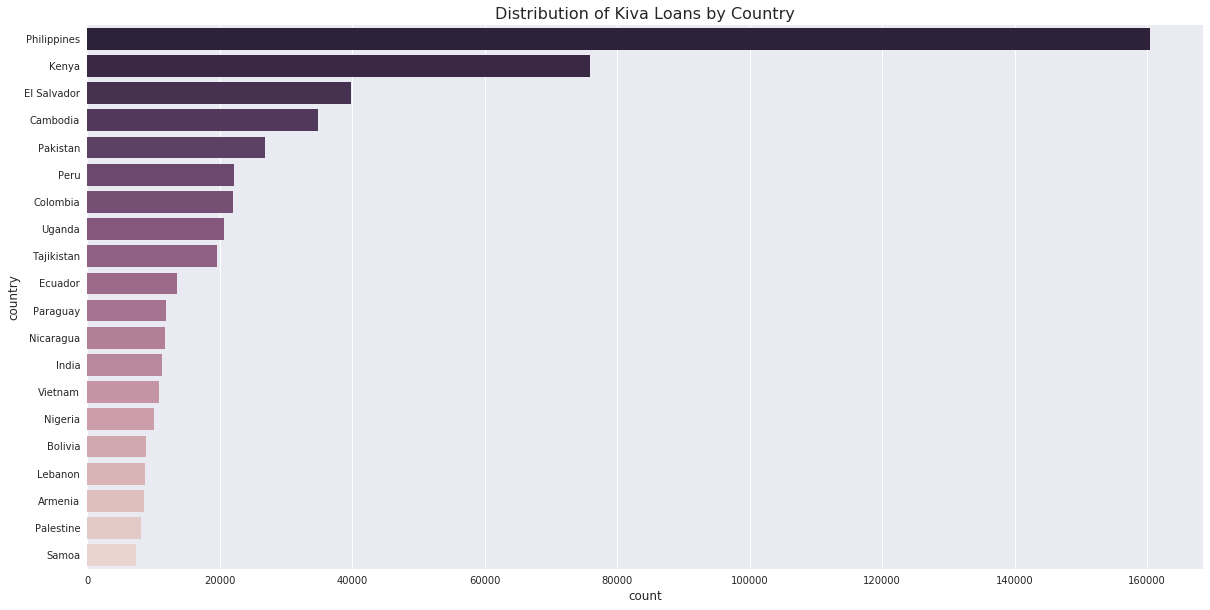

In [148]:
# Plot loans per country
sns.countplot(y="country", data=kiva_loans_df, 
              order=kiva_loans_df.country.value_counts().iloc[:20].index).set_title("Distribution of Kiva Loans by Country")

Text(0.5,1,'Distribution of Kiva Loans by Region')

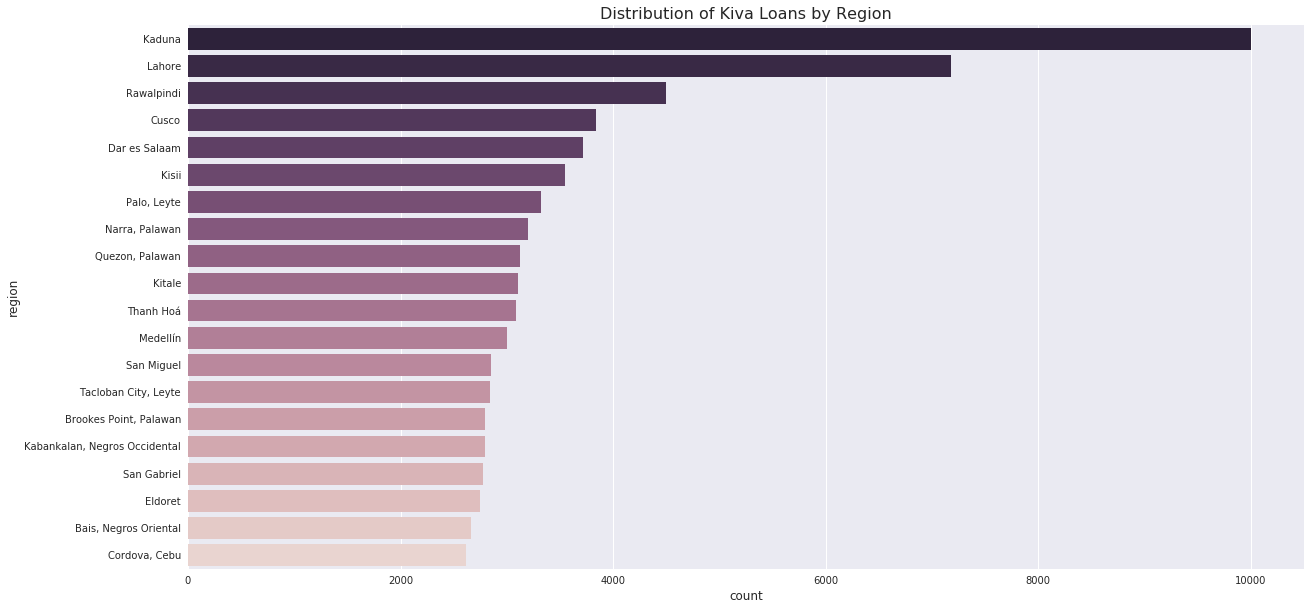

In [149]:
# Plot loans per region
sns.countplot(y="region", data=kiva_loans_df, 
              order=kiva_loans_df.region.value_counts().iloc[:20].index).set_title("Distribution of Kiva Loans by Region")

Let us plot the total number loan requests on a map to better visualise where the Kiva loan requests are mostly coming from.

In [150]:
countries_number_loans = kiva_loans_df.groupby('country').count()['loan_amount'].sort_values(ascending = False)
data = [dict(
        type='choropleth',
        locations= countries_number_loans.index,
        locationmode='country names',
        z=countries_number_loans.values,
        text=countries_number_loans.index,
        colorscale = [[0,'rgb(216, 191, 216)'],[1,'rgb(75, 0, 130)']],
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Number of Loans Requested by Country'),
)]
layout = dict(title = 'Number of Loans Requested by Country', 
        geo = dict(
            showframe = False, 
            showcoastlines = True, 
            projection = dict(type = 'Mercator')
        ))
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='loans-total-map')

Let us have a look at whether is a similar case for the total loan amount requested.

In [151]:
countries_loan_amount = kiva_loans_df.groupby('country').sum()['loan_amount'].sort_values(ascending = False)
data = [dict(
        type='choropleth',
        locations= countries_loan_amount.index,
        locationmode='country names',
        z=countries_loan_amount.values,
        text=countries_loan_amount.index,
        colorscale = [[0,'rgb(216, 191, 216)'],[1,'rgb(75, 0, 130)']],
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Total Loan Amount Requested by Country'),
)]
layout = dict(title = 'Total Loan Amount Requested by Country', 
        geo = dict(
            showframe = False, 
            showcoastlines = True, 
            projection = dict(type = 'Mercator')
        ))
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='loans-total-map')

Now a quick look at the distribution of loan requests per sector.

Text(0.5,1,'Distribution of Loans by Sector')

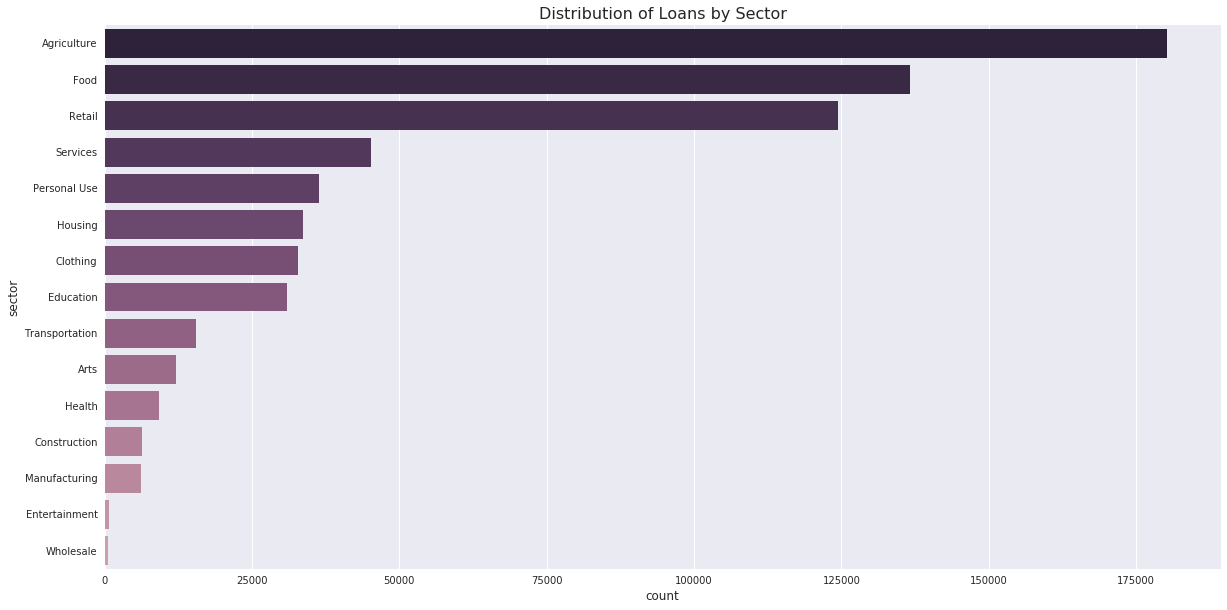

In [152]:
# Plot loans per sector
sns.countplot(y="sector", data=kiva_loans_df, 
              order=kiva_loans_df.sector.value_counts().iloc[:20].index).set_title("Distribution of Loans by Sector")

Let us look at the distribution of loan amounts. Note, the initial plot was unreadable due to an outlier so it has been truncated as a first step before plotting.

In [153]:
# Truncate outliers
percentile_99 = np.percentile(kiva_loans_df.loan_amount.values, 99)
kiva_loans_df['loan_amount_trunc'] = kiva_loans_df['loan_amount'].copy()
kiva_loans_df.loc[kiva_loans_df['loan_amount_trunc'] > percentile_99, 'loan_amount_trunc'] = percentile_99

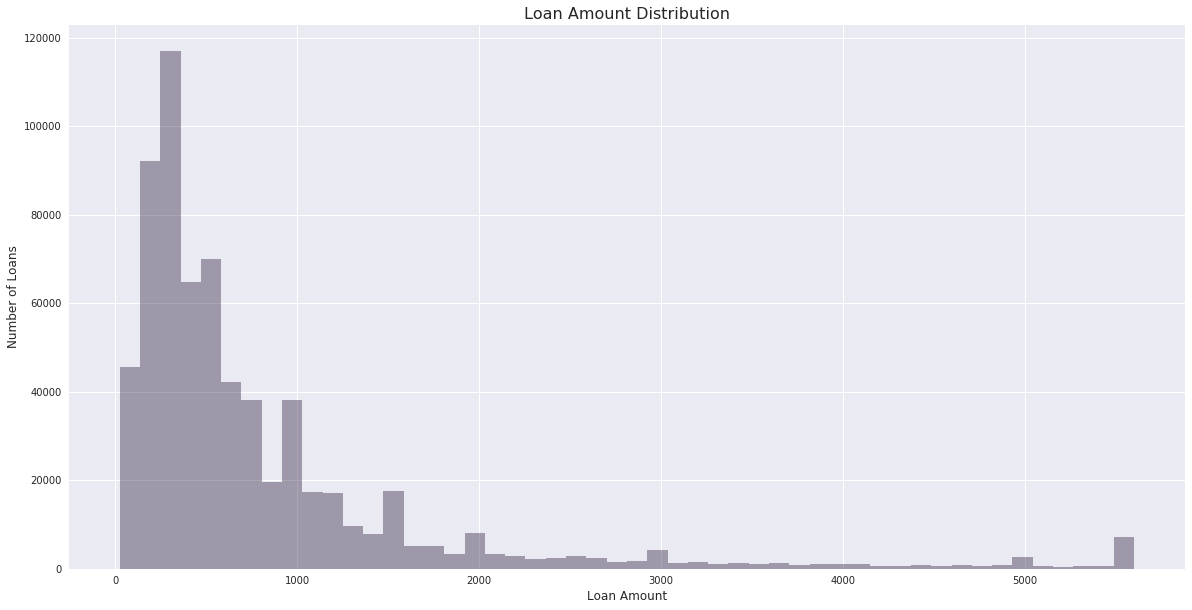

In [154]:
# Plot loan amount histogram
sns.distplot(kiva_loans_df.loan_amount_trunc.values, kde=False)
plt.title("Loan Amount Distribution")
plt.xlabel('Loan Amount')
plt.ylabel('Number of Loans')
plt.show()

Let us visualise the repayment term and interval of the Kiva loans.

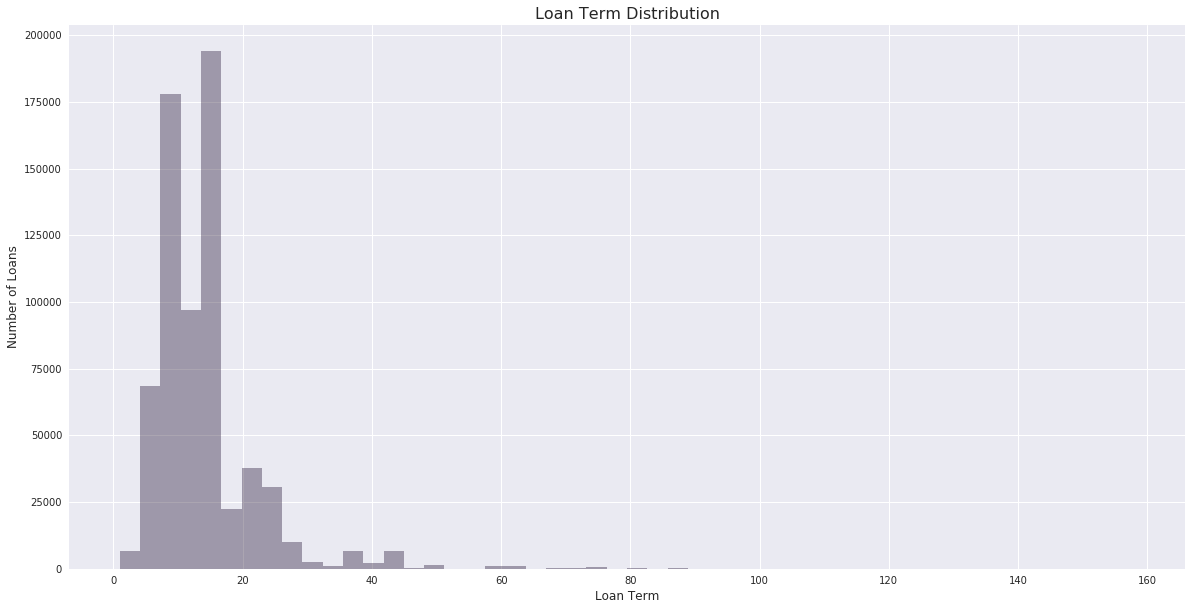

In [155]:
# Plot repayent term histogram
sns.distplot(kiva_loans_df.term_in_months.values, kde=False)
plt.title("Loan Term Distribution")
plt.xlabel('Loan Term')
plt.ylabel('Number of Loans')
plt.show()

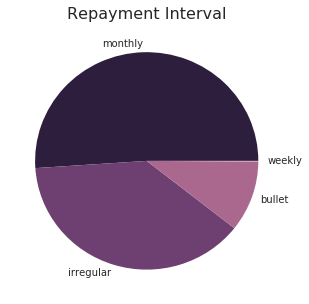

In [156]:
# Plot repayment interval of loans
with sns.cubehelix_palette(5, reverse=True):
    plt.figure(figsize=(5,5))
    plt.title("Repayment Interval")
    kiva_loans_df.repayment_interval.value_counts().T.plot.pie(labeldistance=1.08)
    plt.ylabel('')

### Multi-dimensional Poverty Index (MPI)  <a name="mpi_eda"/>

The MPI identifies deprivations across the three dimensions and shows the number of people who are multidimensionally poor (suffering deprivations in 33% or more of the weighted indicators). 

More information at http://hdr.undp.org/en/content/multidimensional-poverty-index-mpi.

In [157]:
print(kiva_mpi_locations_df.shape)
kiva_mpi_locations_df.sample(5)

(2772, 9)


LocationName  ISO      country      region  \
836   Usulutan, El Salvador  SLV  El Salvador    Usulutan   
1652                    NaN  NaN          NaN         NaN   
617           Dedza, Malawi  MWI       Malawi       Dedza   
323   Chiquimula, Guatemala  GTM    Guatemala  Chiquimula   
473     Prey Veng, Cambodia  KHM     Cambodia   Prey Veng   

                     world_region    MPI                               geo  \
836   Latin America and Caribbean  0.030  (13.4470634, -88.55653099999999)   
1652                          NaN    NaN                  (1000.0, 1000.0)   
617            Sub-Saharan Africa  0.314         (-14.3816618, 34.3254842)   
323   Latin America and Caribbean  0.200         (14.7924897, -89.5450458)   
473     East Asia and the Pacific  0.120         (11.3802442, 105.5005483)   

            lat         lon  
836   13.447063  -88.556531  
1652        NaN         NaN  
617  -14.381662   34.325484  
323   14.792490  -89.545046  
473   11.380244  105.500548

Looking at the MPI dataset we notice that there are a lot of missing values to deal with. The main features we are interested in are LocationName, country, region and MPI so we will drop all the entries that don't have these values.
(Note: LocationName is available wherever country and region are available so we will keep and use this column too.)

In [158]:
print("Original MPI dataset: ", kiva_mpi_locations_df.shape)
region_mpi_df = kiva_mpi_locations_df[['LocationName', 'country','region', 'MPI']]
region_mpi_df = region_mpi_df.dropna()
print("Cleaned MPI dataset: ", region_mpi_df.shape)

Original MPI dataset:  (2772, 9)
Cleaned MPI dataset:  (984, 4)


Unfortunately a lot of data was discarded at this step, however we will proceed with it and may have to source region-MPI mappings from other external datasets later on.

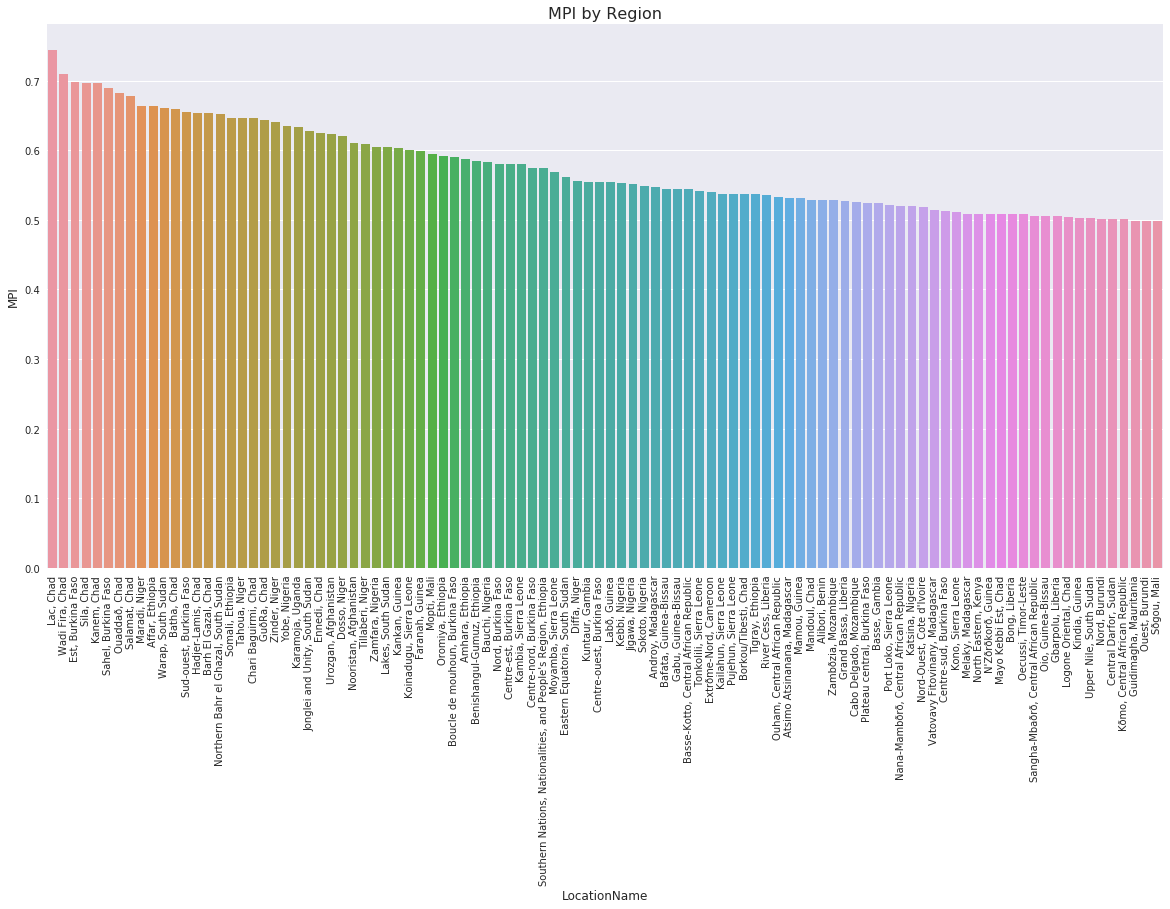

In [159]:
# Plot MPI by Region
region_mpi_df.sort_values(by="MPI", ascending=False, inplace=True)

mpi_top_regions = region_mpi_df.head(100)
sns.barplot(mpi_top_regions.LocationName, mpi_top_regions.MPI)

plt.title("MPI by Region")
plt.xticks(rotation=90)
plt.show()

In [160]:
data = [ dict(
        type = 'scattergeo',
        lon = kiva_mpi_locations_df['lon'],
        lat = kiva_mpi_locations_df['lat'],
        text = kiva_mpi_locations_df['LocationName'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = [[0,'rgb(216, 191, 216)'],[1,'rgb(75, 0, 130)']],
            cmin = 0,
            color = kiva_mpi_locations_df['MPI'],
            cmax = kiva_mpi_locations_df['MPI'].max(),
            colorbar=dict(
                title="Multi-dimenstional Poverty Index"
            )
        ))]

layout = dict(title = 'MPI by Country', 
        geo = dict(
            showframe = False, 
            showcoastlines = True, 
            projection = dict(type = 'Mercator')
        ))
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='mpi-region-map')

## Combining Kiva Loan Data with MPI  <a name="combining_loan_mpi"/>

In this section we will join the Kiva Loan data with the MPI dataset to try and get an understanding of the relationship between loan requests and MPI.

### Data Preprocessing <a name="preprocessing"/>

We will do the same removal of entries with no country or region for the Kiva Loans dataset. We will also drop a few less relevant features and then join the MPI information to the Loan information.

In [170]:
print("Original Kiva Loans dataset: ", kiva_loans_df.shape)
kiva_loans_mpi_df = kiva_loans_df.dropna(subset = ['country','region'])
#kiva_loans_mpi_df = kiva_loans_mpi_df.drop(columns=['id', 'use', 'country_code', 'partner_id', 'lender_count'])
print("Cleaned Kiva Loans dataset: ", kiva_loans_mpi_df.shape)

kiva_loans_mpi_df= pd.merge(kiva_loans_mpi_df, region_mpi_df, how='left')
kiva_loans_mpi_df.sample(5)

SyntaxError: EOL while scanning string literal (<ipython-input-170-0ae9823e4b4f>, line 6)

It looks like there were not many matches of country and region and we have quite a few missing MPI values. We will have to drop these entries as well. Again, note, we are losing a lot of data here but we will proceed for now with the given datasets and later on explore other data sets that may provide better mappings.

In [162]:
print("Original Kiva MPI Loans dataset: ", kiva_loans_df.shape)
kiva_loans_mpi_df = kiva_loans_mpi_df.dropna(subset=['MPI'])
print("Cleaned Kiva MPI dataset: ", kiva_loans_mpi_df.shape)

Original Kiva MPI Loans dataset:  (671205, 21)
Cleaned Kiva MPI dataset:  (50955, 17)


### Analysis <a name="analysis"/>

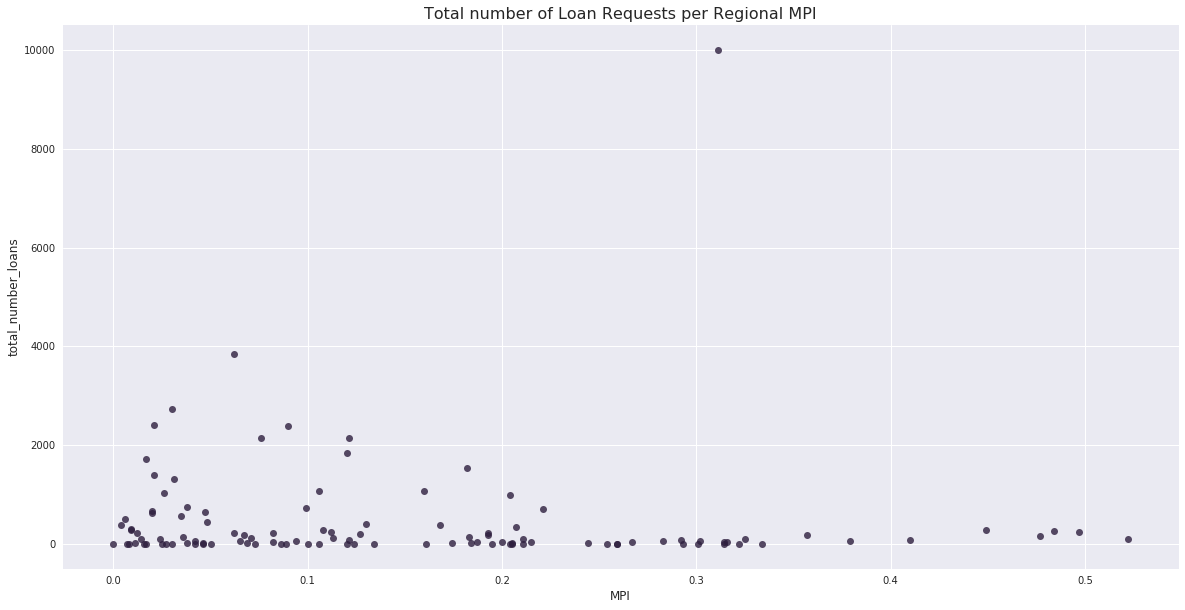

In [163]:
# Scatter plot of number of loans per MPI
total_loans_mpi_df = kiva_loans_mpi_df.groupby(['country','region','MPI'])['loan_amount'].count().reset_index(name='total_number_loans')
total_loans_mpi_df.sample(5)
sns.regplot(x = total_loans_mpi_df.MPI, y = total_loans_mpi_df.total_number_loans, fit_reg=False)
plt.title("Total number of Loan Requests per Regional MPI")
plt.show()

The total number of loan requests to Kiva is actually higher in the countries with a lower MPI (ie: countries that have less poverty, although note as I understand it they do have substantial poverty to even receive a MPI score). There is also one outlier with an extremely high total number of requests.

In [164]:
# Examine outliers
percentile_95_df = total_loans_mpi_df[total_loans_mpi_df.total_number_loans > total_loans_mpi_df.total_number_loans.quantile(.95)]
percentile_95_df.sort_values('total_number_loans', ascending=False).head(10)

country      region    MPI  total_number_loans
73       Nigeria      Kaduna  0.311               10000
79          Peru       Cusco  0.062                3841
16   El Salvador  San Miguel  0.030                2737
68     Nicaragua     Managua  0.021                2405
26     Guatemala      Solola  0.090                2383
101       Uganda     Kampala  0.076                2149

One thing to note here is that we don't see the regions of the Philippines listed among the top regions requesting loans, although it was our top country for loan requests (see Quick EDA of Kiva Loans). One reason for this may be that the Philippines is broken down into many more, smaller regions than some of the countries/regions we see listed in this case. Another reason may be that we have dropped it as it didn't have a MPI mapping. Lets check.

In [165]:
# Regions per country
regions_per_country_df = kiva_loans_mpi_df.groupby(['country']).size().reset_index(name='region_count')
regions_per_country_df.sort_values('region_count', ascending=False).head(5)

country  region_count
2      Cambodia         10781
16      Nigeria         10000
15    Nicaragua          8764
18         Peru          5148
4   El Salvador          3436

In [166]:
# Philippines
print(kiva_loans_mpi_df.loc[kiva_loans_mpi_df['country'] == 'Philippines'])

Empty DataFrame
Columns: [funded_amount, loan_amount, activity, sector, country, region, currency, posted_time, disbursed_time, funded_time, term_in_months, tags, borrower_genders, repayment_interval, date, loan_amount_trunc, MPI]
Index: []


Theory two is correct, we have lost that data. We will proceed for now but notice we are seeing a stronger need to use some external data with better mappings.

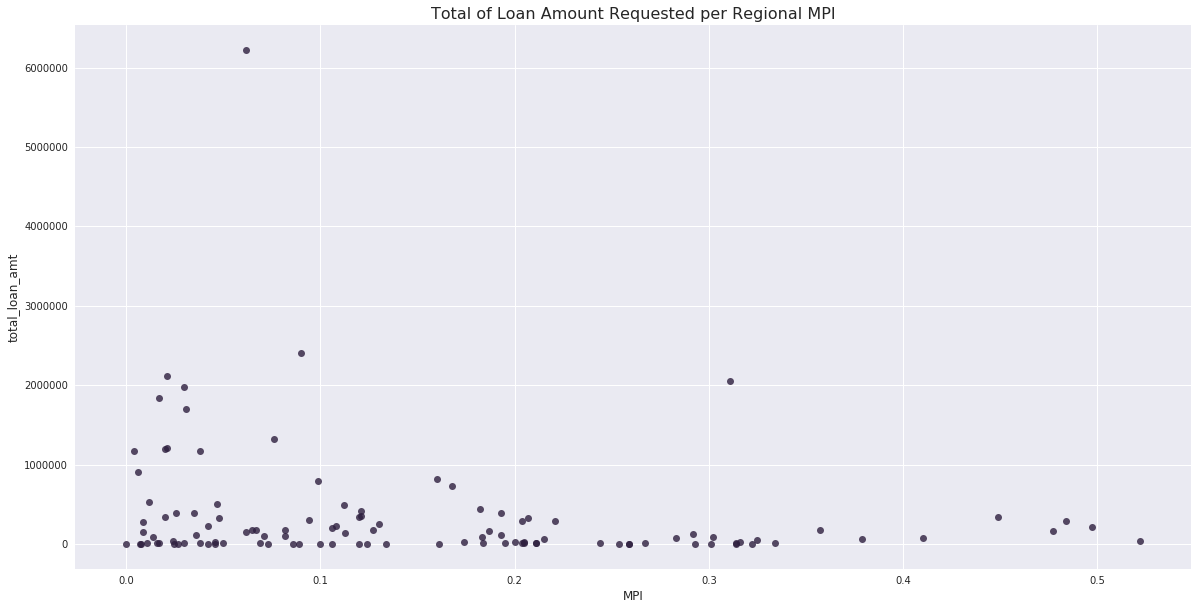

In [167]:
# Scatter plot of total loan amount per MPI
total_loan_amt_df = kiva_loans_mpi_df.groupby(['country','region','MPI'])['loan_amount'].sum().reset_index(name='total_loan_amt')
sns.regplot(x = total_loan_amt_df.MPI, y = total_loan_amt_df['total_loan_amt'], fit_reg = False)
plt.title("Total of Loan Amount Requested per Regional MPI")
plt.show()

In [168]:
# Examine outliers
percentile_95_df = total_loan_amt_df[total_loan_amt_df.total_loan_amt > total_loan_amt_df.total_loan_amt.quantile(.95)]
percentile_95_df.sort_values('total_loan_amt', ascending=False).head(10)

country      region    MPI  total_loan_amt
79         Peru       Cusco  0.062       6222075.0
26    Guatemala      Solola  0.090       2406175.0
68    Nicaragua     Managua  0.021       2117975.0
73      Nigeria      Kaduna  0.311       2048900.0
16  El Salvador  San Miguel  0.030       1973650.0
69    Nicaragua      Masaya  0.017       1833650.0

Total loan amount exhibits a similar trend to total number of loan requests. 

The trend is interesting as one would have expected the opposite - countries with higher MPI would request more loans. A possible explanation for the opposite may be that as MPI increases, the ability of these people to even request loans through Kiva decreases. For example, due to lack of knowledge about loans and the application process, lack of tools to apply for the loan in the first place, etc.

What may be important is that the people from high MPI regions who do request funds get them. Let us plot the percentage of funded loan amount according to regional MPI.

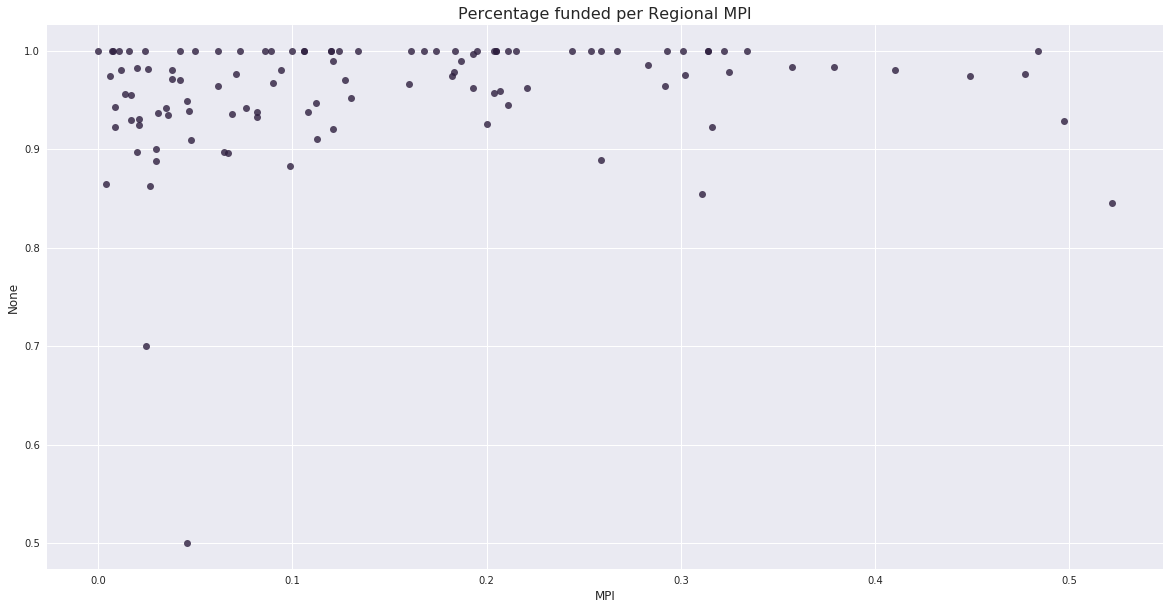

In [169]:
# Scatter plot of total loan amount per MPI
total_funded_amt_df = kiva_loans_mpi_df.groupby(['country','region','MPI'])['funded_amount'].sum().reset_index(name='total_funded_amt')
total_loan_amt_df= pd.merge(total_loan_amt_df, total_funded_amt_df, how='left')
sns.regplot(x = total_loan_amt_df.MPI, y = total_loan_amt_df['total_funded_amt']/total_loan_amt_df['total_loan_amt'], fit_reg = False)
plt.title("Percentage funded per Regional MPI")
plt.show()

It is great to see that so many loans have been fully funded! However, it looks like there is currently no strong relationship between regional MPI and the probability of a loan funded.

## Next Steps  <a name="eda"/>

- Investigate borrower gender 
- Start incorporating some external data to get better mappings of MPI to Kiva Loans
- Investigate MPI per sector, activity, repayment type

*To be continued.*